# Project ideas and thoughts:
- Identify 3 demographic groups:
    - customers who respond to offers (received, viewed, and completed the offer)
    - customers who don't respond to offers (received, viewed, not completed the offer)
    - customers who completed offers without viewing the offers (those who would have made a purchase without the offer)


- Predict offer completion rate per customer
- Send offers to customers with a certain threshold completion rate
- Exclude customers who would make a purchase without the offer

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, plot_roc_curve
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
plt.style.use('seaborn-whitegrid')

In [2]:
# read in the cleaned datasets
offers = pd.read_csv('cleaned_data/offers.csv')
customers = pd.read_csv('cleaned_data/customers.csv')
events = pd.read_csv('cleaned_data/events.csv')
print(f'offers has {len(offers)} rows')
print(f'customers has {len(customers)} rows')
print(f'events has {len(events)} rows')

offers has 10 rows
customers has 16994 rows
events has 306514 rows


# Define Customer Response
- A user can receive an offer, never actually view the offer, and still complete the offer
- We want to find customers who were influenced by the offer - those who **RECEIVED, VIEWED, AND COMPLETED THE OFFER**
- Also, we want to find customers who would have made purchases without offers - those who **RECEIVED, COMPLETED, BUT DIDN'T VIEW THE OFFER**

The purpose of this project is to help Starbucks better decisions on sending out offers in order to save money and increase sales. If we are able to predict customer response to offers, we can help reduce losses in revenue (discount, buy one get one free) by not sending offers to certain customers, as well as increase sales by sending offers to certain customers.

In [5]:
# # Merge offers to events
# events_offers = pd.merge(events, offers, how='left', left_on='offer_id', right_on='id')
# #events_offers = events_offers.query("event != 'transaction'") #include only offer related activities
# events_offers = events_offers.query("offer_type != 'informational'") #include only offers that can be tracked with completion
# events_offers.drop(['id'],axis=1,inplace=True)

# offerid_dict = dict(zip(set(events_offers.offer_id), [i for i in 'ABCDEFGHIJ']))
# events_offers.offer_id = events_offers.offer_id.apply(lambda x: offerid_dict[x])
# events_offers.reset_index(drop=True, inplace=True)

# removed_customers = np.setdiff1d(events.customer_id.unique(), events_offers.customer_id.unique(), assume_unique=True)

# # # Create dummy variables for channels
# # mlb = MultiLabelBinarizer()
# # dummy_channels = pd.DataFrame(mlb.fit_transform(events_offers.channels), columns=mlb.classes_)
# # events_offers = pd.concat([events_offers,dummy_channels],axis=1)
# # events_offers.drop('channels',axis=1,inplace=True)
# # print(f'Unique offer types are: {events_offers.offer_type.unique()}')
# # print(f'There are {events_offers.offer_id.nunique()} unique offers in the dataset')
# print(len(removed_customers), 'customers are removed from the filter')
# print(events_offers.event.unique())
# print(events_offers.offer_type.unique())
# print(events_offers.offer_id.unique())
# events_offers.head()

### Merge events and offers dataframes into events_offers dataframe
- Remove transactions to only include 3 events/activities:
    - offer received
    - offer viewed
    - offer completed
- Remove informational offers to only include 2 offer types:
    - bogo
    - discount
- Converted 8 unique offer ids to letters from A to H for more in-depth analysis later on

In [3]:
# Add offer info into events dataset
events = pd.merge(events, offers[['id','offer']], how='left', left_on='offer_id', right_on='id').drop(['id','offer_id'],axis=1)
events.head()

,customer_id,event,hour,amount_spent,reward_received,offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,bogo_5_7_5
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,discount_20_10_5
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,discount_10_7_2
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,discount_10_10_2
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,bogo_10_5_10


In [4]:
events.offer.unique()

array(['bogo_5_7_5', 'discount_20_10_5', 'discount_10_7_2',
       'discount_10_10_2', 'bogo_10_5_10', 'bogo_5_5_5', 'discount_7_7_3',
       'informational_0_4_0', 'bogo_10_7_10', 'informational_0_3_0', nan],
      dtype=object)

In [5]:
informational_offers = ['informational_0_3_0','informational_0_4_0']
discount_offers = ['discount_20_10_5','discount_10_7_2','discount_10_10_2','discount_7_7_3']
bogo_offers = ['bogo_5_7_5','bogo_10_5_10','bogo_5_5_5','bogo_10_7_10']

In [6]:
# Remove informational events out of events data
informational_events = events[events.offer.isin(informational_offers)]
events = events[~events.offer.isin(informational_offers)]

In [7]:
# Create dataset offer_events to just analyze offers related events
offer_events = events[events.event != 'transaction']

# Create customer_funnels dataset
customer_funnels = offer_events.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
customer_funnels = pd.pivot(customer_funnels, index='customer_id', columns='event', values='count')
customer_funnels.columns = [col.replace(' ', '_') for col in customer_funnels.columns]
customer_funnels['completion_rate'] = customer_funnels.offer_completed / customer_funnels.offer_received
customer_funnels.sample(5)

,offer_completed,offer_received,offer_viewed,completion_rate
customer_id,,,,
88aa10c94fe343c3af26533143dcd1f2,4.0,4.0,2.0,1.000000
d3fd6d671fa041428d961950d5470ec2,1.0,3.0,2.0,0.333333
c76a491aa41a473fbb462bdd96a7f03d,2.0,3.0,2.0,0.666667
9b57b7bc4ea24fc1a3d2f4760a141941,3.0,5.0,4.0,0.600000
d105c60598cd410eab1e21e59c3fc613,2.0,4.0,2.0,0.500000


- 100% customers in this data received at least 1 offer
- 24.5% customers didn't complete the offer
- 2.4% customers didn't view the offer

In [8]:
customer_funnels.isnull().mean() * 100

offer_completed    24.539225
offer_received      0.000000
offer_viewed        2.392486
completion_rate    24.539225
dtype: float64

# Explore 3 demographic groups
- What are their demographic distributions?
- What are their average spending per week?
- What are their average transactions per week?

In [9]:
def create_3_demo_groups(funnel):

    responded = funnel.dropna()
    not_responded = funnel[funnel.offer_completed.isnull()]
    completed_not_viewed = funnel[funnel.offer_completed.notnull() & funnel.offer_viewed.isnull()]

    print(round(len(responded)/len(funnel)*100,2), '% customers responded to offers')
    print(round(len(not_responded)/len(funnel)*100,2), '% customers did not respond to any offer')
    print(round(len(completed_not_viewed)/len(funnel)*100,2), '% customers completed offers without viewing offer')

    # Make sure these 3 demographic groups are broken down correctly
    assert len(responded) + len(not_responded) + len(completed_not_viewed) == len(funnel), '3 demographic groups not broken down correctly'  

    return responded, not_responded, completed_not_viewed

In [10]:
responded, not_responded, completed_not_viewed = create_3_demo_groups(customer_funnels)

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


### Those who completed and not viewed have slightly less completion rate than responded customers

In [11]:
# sns.distplot(responded.completion_rate, label='responded');
# sns.distplot(completed_not_viewed.completion_rate, label='completed_not_viewed');
# plt.legend();

In [12]:
def get_customer_ids(response_group):

    df = response_group
    return df.index

In [13]:
get_customer_ids(responded)

Index(['0009655768c64bdeb2e877511632db8f', '0011e0d4e6b944f998e987f904e8c1e5',
       '0020c2b971eb4e9188eac86d93036a77', '0020ccbbb6d84e358d3414a3ff76cffd',
       '003d66b6608740288d6cc97a6903f4f0', '00426fe3ffde4c6b9cb9ad6d077a13ea',
       '004b041fbfe44859945daa2c7f79ee64', '004c5799adbf42868b9cff0396190900',
       '005500a7188546ff8a767329a2f7c76a', '0056df74b63b4298809f0b375a304cf4',
       ...
       'ffd53e5ba61d41378b66efc00d9f9682', 'ffda4545e7084ff6aaf01304fb1c1fa6',
       'ffdefcac307f4ca99ac1ebd51470f106', 'ffe5257abf8840b395e1ee6b29894637',
       'ffeaa02452ef451082a0361c3ca62ef5', 'fff29fb549084123bd046dbc5ceb4faa',
       'fff3ba4757bd42088c044ca26d73817a', 'fff7576017104bcc8677a8d63322b5e1',
       'fffad4f4828548d1b5583907f2e9906b', 'ffff82501cea40309d5fdd7edcca4a07'],
      dtype='object', name='customer_id', length=12595)

In [14]:
customers[customers.age == 118]

,gender,age,id,became_member_on,income
0,NaN,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,NaN,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,NaN,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,NaN,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,NaN,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16974,NaN,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16976,NaN,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16983,NaN,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16985,NaN,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [15]:
customers.age = customers.age.replace({118:np.nan})
customers.dropna(inplace=True)

In [16]:
# Create new feature for customer data - membership_days
customers.became_member_on = pd.to_datetime(customers.became_member_on, format='%Y%m%d')
most_recent = max(customers.became_member_on)
customers['membership_days'] = customers.became_member_on.apply(lambda x: most_recent - x).dt.days

### Analyze demographics for the 3 response groups
- If we look at the "not responded" group (orange distribution), we can conclude that customers with young age, low income, and a short period of membership are likely to not respond to offers
- The green and blue distributions are relatively similar, while the green distribution (completed the offer without viewing) is slightly skewed to higher age, higher income, and longer membership period

In [17]:
def plot_compare_3_groups(funnel):

    responded, not_responded, completed_not_viewed = create_3_demo_groups(funnel)

    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    sns.distplot(customers[customers.id.isin(get_customer_ids(responded))].age, label='responded');
    sns.distplot(customers[customers.id.isin(get_customer_ids(not_responded))].age, label='not responded');
    sns.distplot(customers[customers.id.isin(get_customer_ids(completed_not_viewed))].age, label='completed not viewed');
    plt.legend();

    plt.subplot(1,3,2)
    sns.distplot(customers[customers.id.isin(get_customer_ids(responded))].income, label='responded');
    sns.distplot(customers[customers.id.isin(get_customer_ids(not_responded))].income, label='not responded');
    sns.distplot(customers[customers.id.isin(get_customer_ids(completed_not_viewed))].income, label='completed not viewed');
    plt.legend();

    plt.subplot(1,3,3)
    sns.distplot(customers[customers.id.isin(get_customer_ids(responded))].membership_days, label='responded');
    sns.distplot(customers[customers.id.isin(get_customer_ids(not_responded))].membership_days, label='not responded');
    sns.distplot(customers[customers.id.isin(get_customer_ids(completed_not_viewed))].membership_days, label='completed not viewed');
    plt.legend();

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


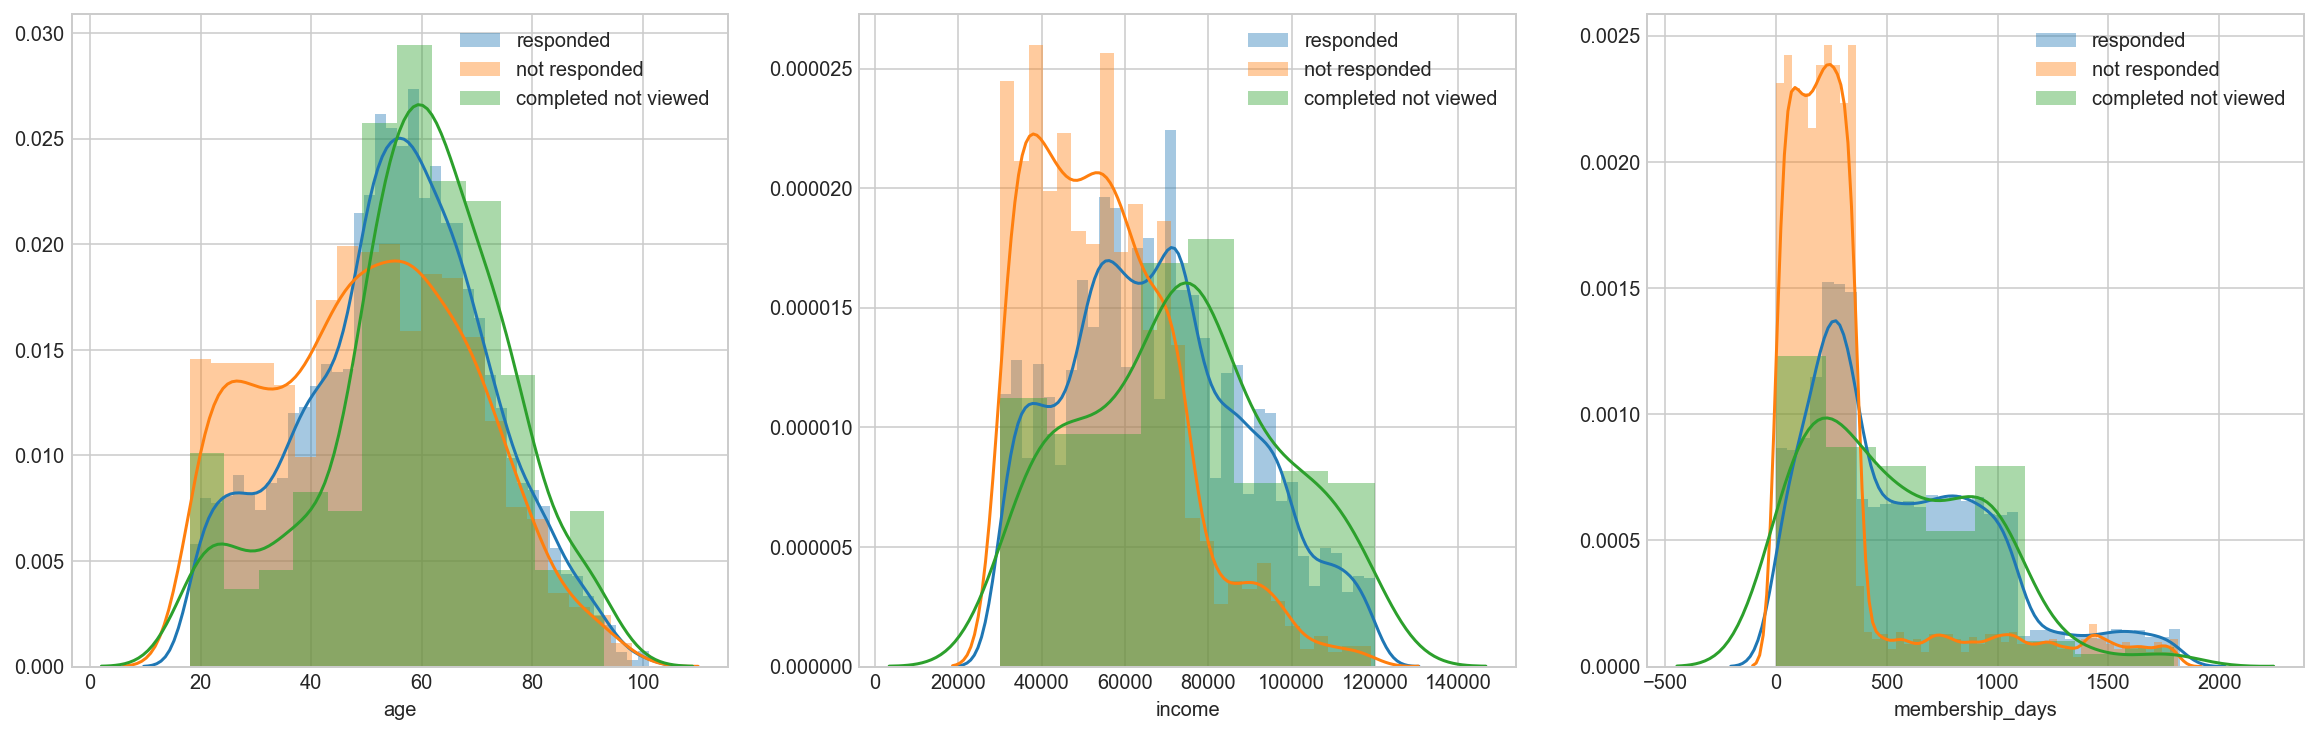

In [18]:
plot_compare_3_groups(customer_funnels)

# Dig deeper into customers funnels by seperating offers

In [92]:
offer_events

,customer_id,event,hour,amount_spent,reward_received,offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,bogo_5_7_5
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,discount_20_10_5
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,discount_10_7_2
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,discount_10_10_2
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,bogo_10_5_10
...,...,...,...,...,...,...
306477,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,NaN,3.0,discount_7_7_3
306486,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,NaN,2.0,discount_10_10_2
306487,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,NaN,NaN,discount_20_10_5
306489,8431c16f8e1d440880db371a68f82dd0,offer completed,714,NaN,2.0,discount_10_10_2


In [19]:
def create_offer_funnels(offer):

    funnel = offer_events[offer_events.offer == offer]
    funnel = funnel.groupby(['customer_id','event']).event.count().to_frame().rename({'event':'count'},axis=1).reset_index()
    funnel = pd.pivot(funnel, index='customer_id', columns='event', values='count')
    funnel.columns = [col.replace(' ', '_') for col in funnel.columns]
    funnel['completion_rate'] = funnel.offer_completed / funnel.offer_received

    return funnel

In [20]:
create_offer_funnels('discount_7_7_3')

,offer_completed,offer_received,offer_viewed,completion_rate
customer_id,,,,
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,1.0,1.0
0020ccbbb6d84e358d3414a3ff76cffd,1.0,1.0,1.0,1.0
0056df74b63b4298809f0b375a304cf4,1.0,1.0,1.0,1.0
0063def0f9c14bc4805322a488839b32,NaN,1.0,1.0,NaN
0092a132ead946ceb30d11a1ed513d20,NaN,1.0,1.0,NaN
...,...,...,...,...
ff992fbec53145bbae59a68d025e0458,1.0,1.0,1.0,1.0
ff9beda564da4bab81633fca744037dc,1.0,1.0,1.0,1.0
ffc6c9fbe34b4578911dcdf6745b4c74,NaN,1.0,1.0,NaN


# Analyze customer response for the 4 discount offers

In [22]:
discount_offers

['discount_20_10_5', 'discount_10_7_2', 'discount_10_10_2', 'discount_7_7_3']

23.09 % customers responded to offers
53.28 % customers did not respond to any offer
23.63 % customers completed offers without viewing offer


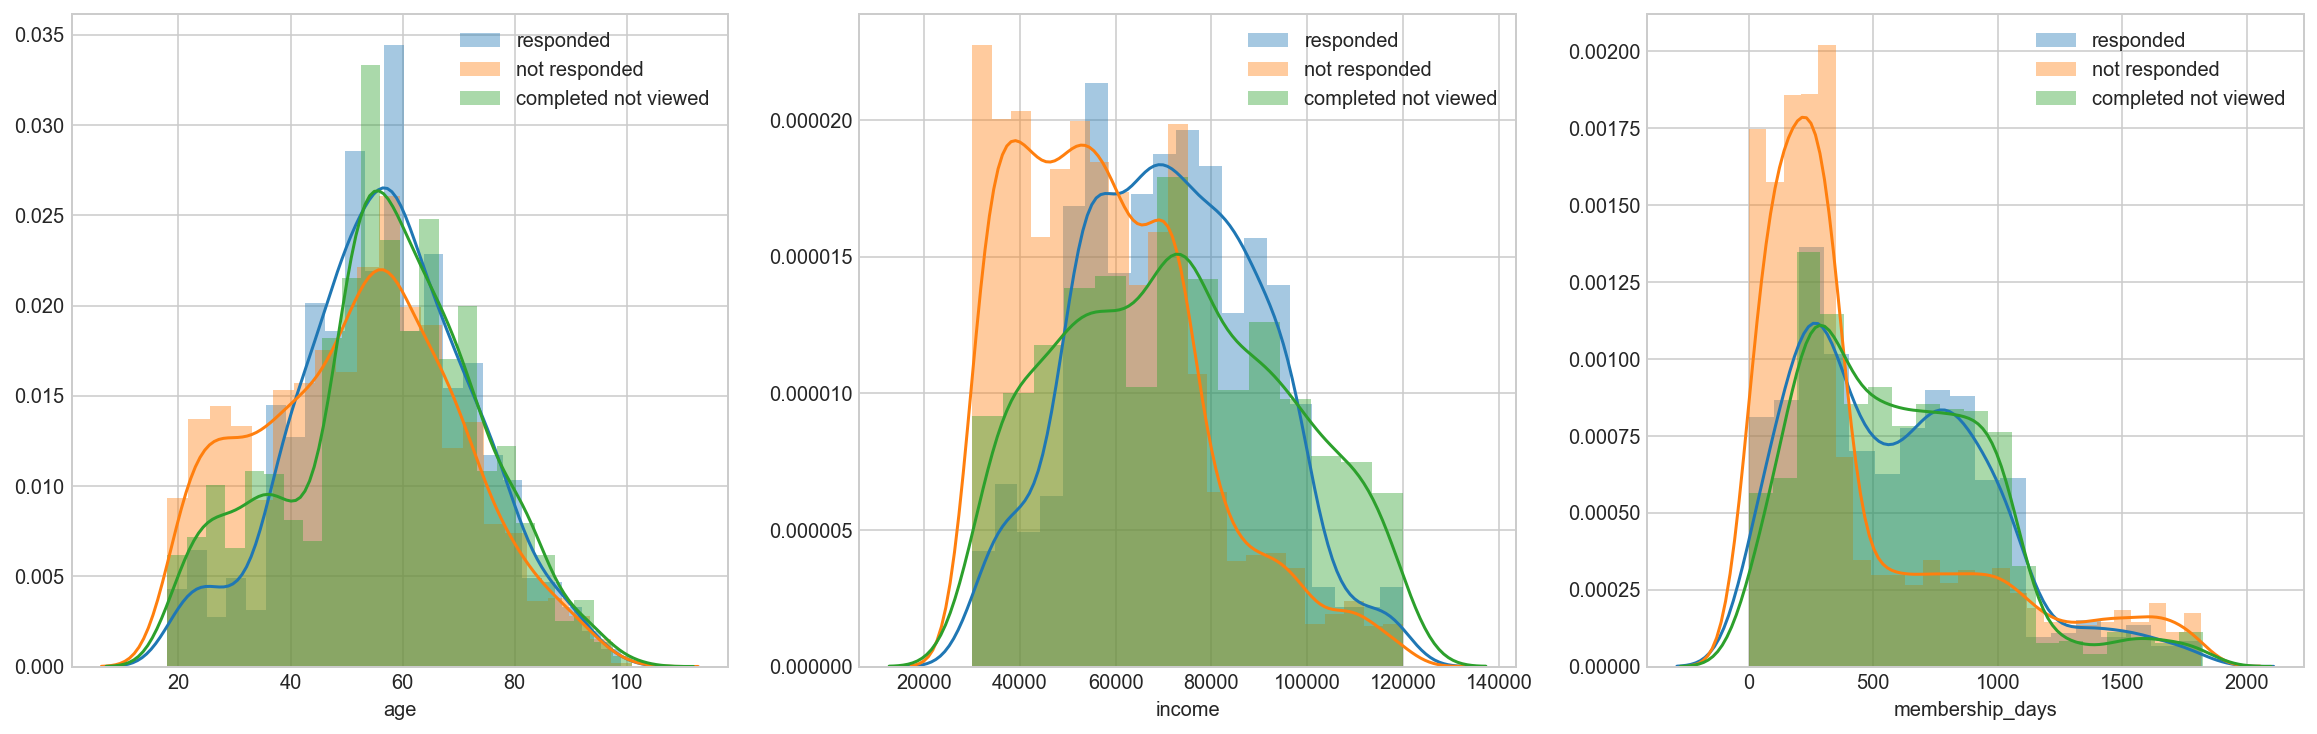

In [23]:
plot_compare_3_groups(create_offer_funnels('discount_20_10_5'))

38.42 % customers responded to offers
44.63 % customers did not respond to any offer
16.95 % customers completed offers without viewing offer


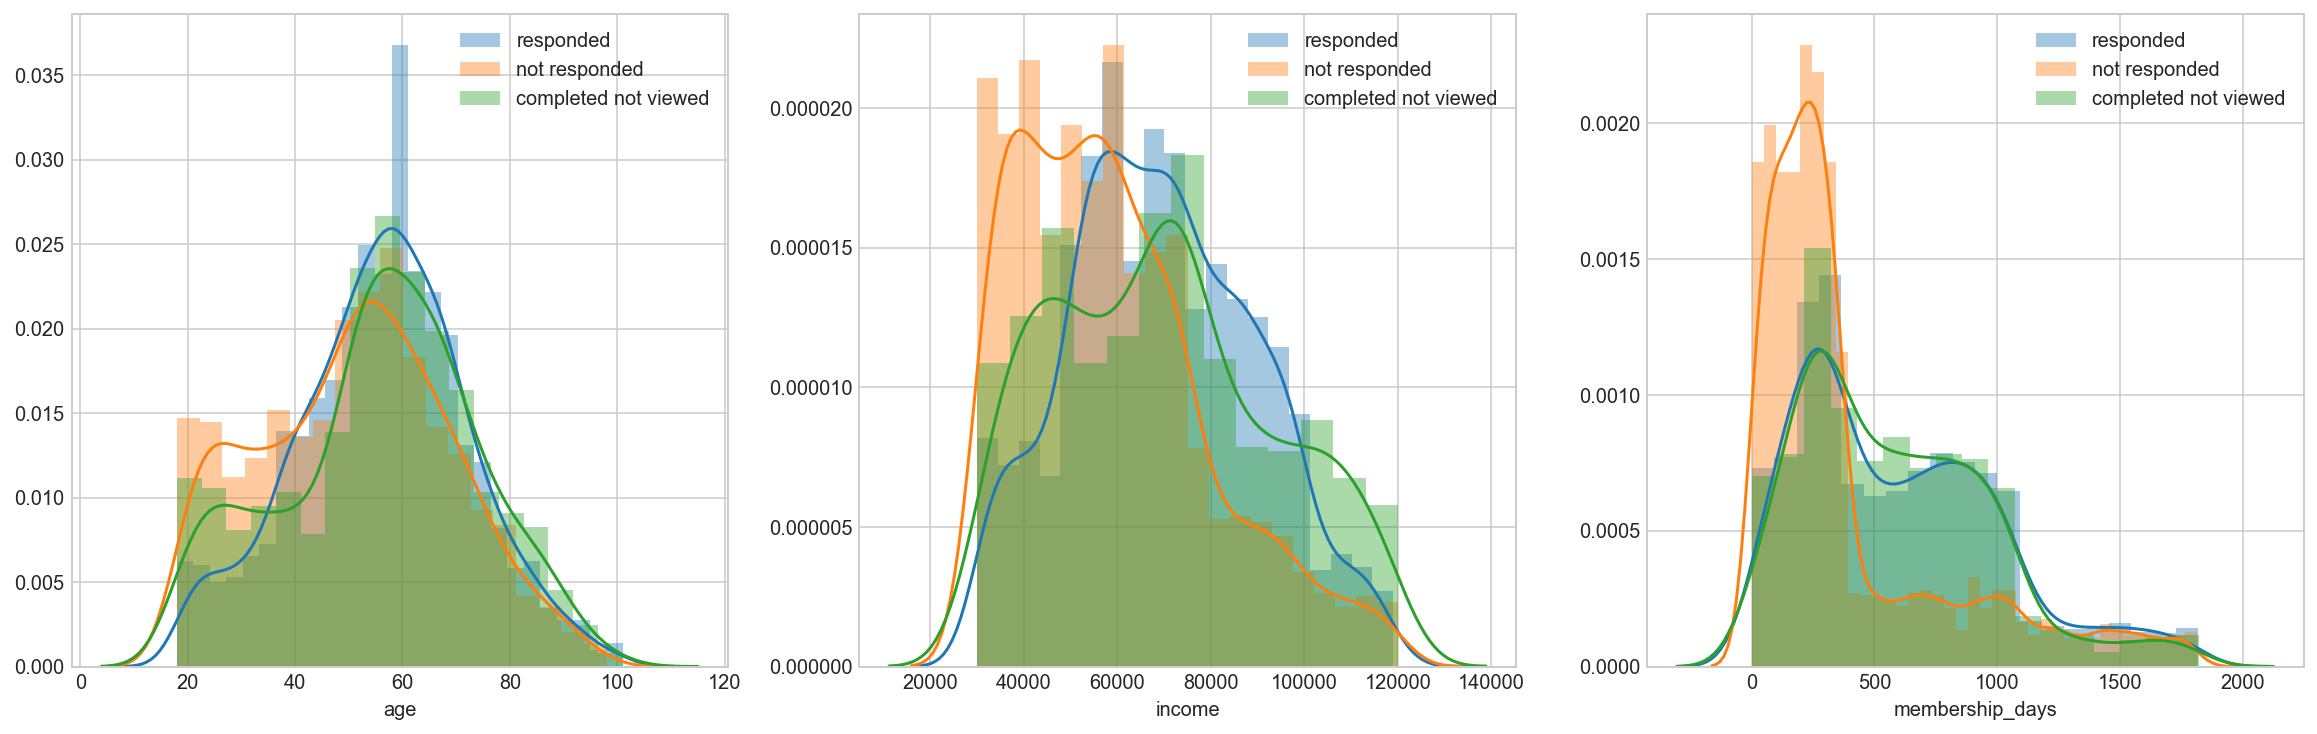

In [25]:
plot_compare_3_groups(create_offer_funnels('discount_10_7_2'))

70.01 % customers responded to offers
28.46 % customers did not respond to any offer
1.53 % customers completed offers without viewing offer


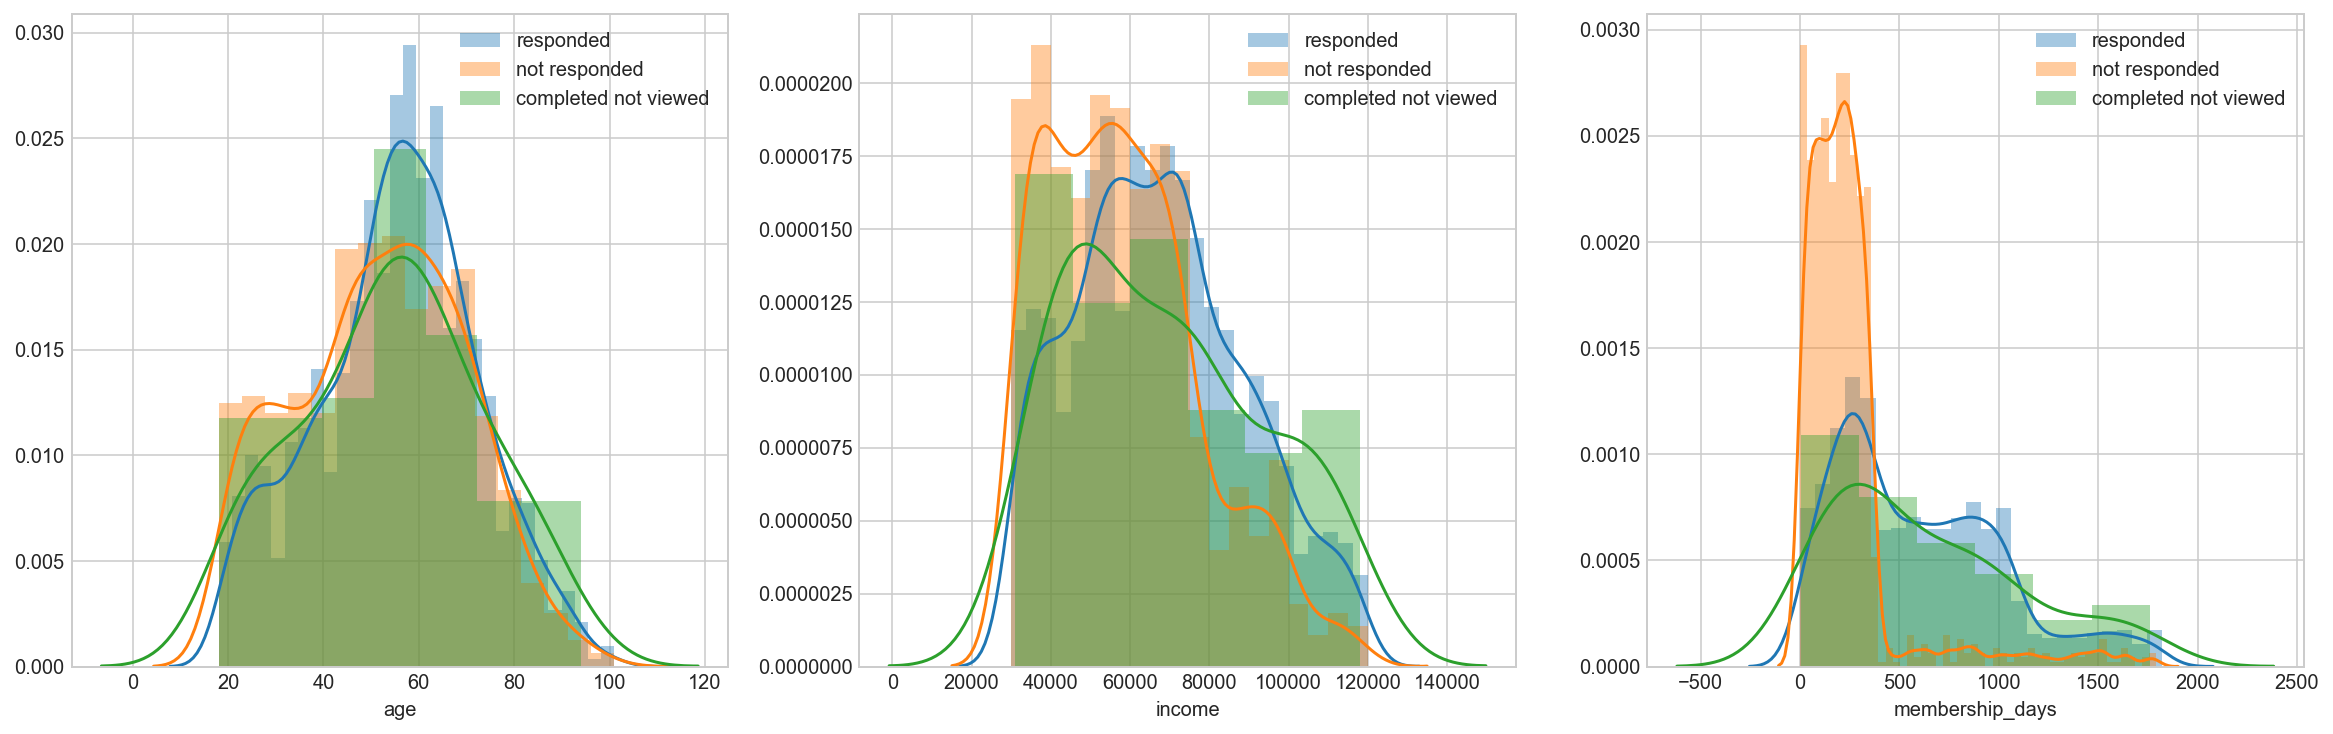

In [26]:
plot_compare_3_groups(create_offer_funnels('discount_10_10_2'))

68.19 % customers responded to offers
30.1 % customers did not respond to any offer
1.71 % customers completed offers without viewing offer


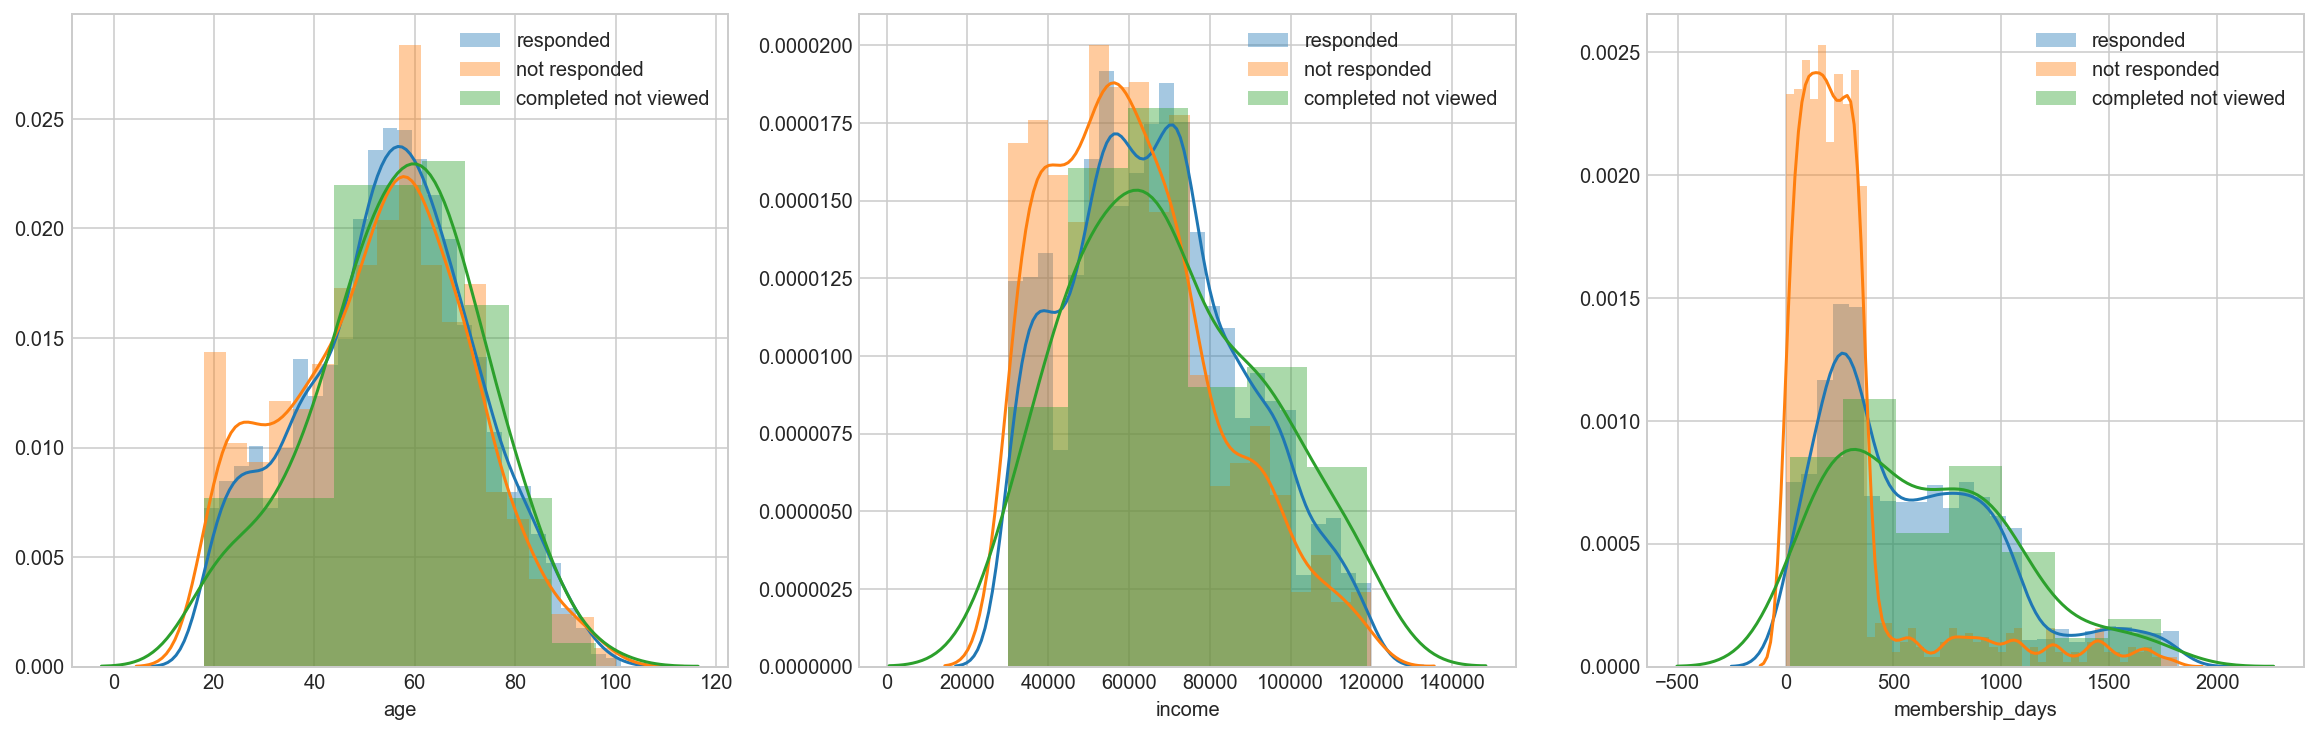

In [21]:
plot_compare_3_groups(create_offer_funnels('discount_7_7_3'))

# Analyze customer response for the 4 BOGO offers

In [27]:
bogo_offers

['bogo_5_7_5', 'bogo_10_5_10', 'bogo_5_5_5', 'bogo_10_7_10']

39.4 % customers responded to offers
40.46 % customers did not respond to any offer
20.14 % customers completed offers without viewing offer


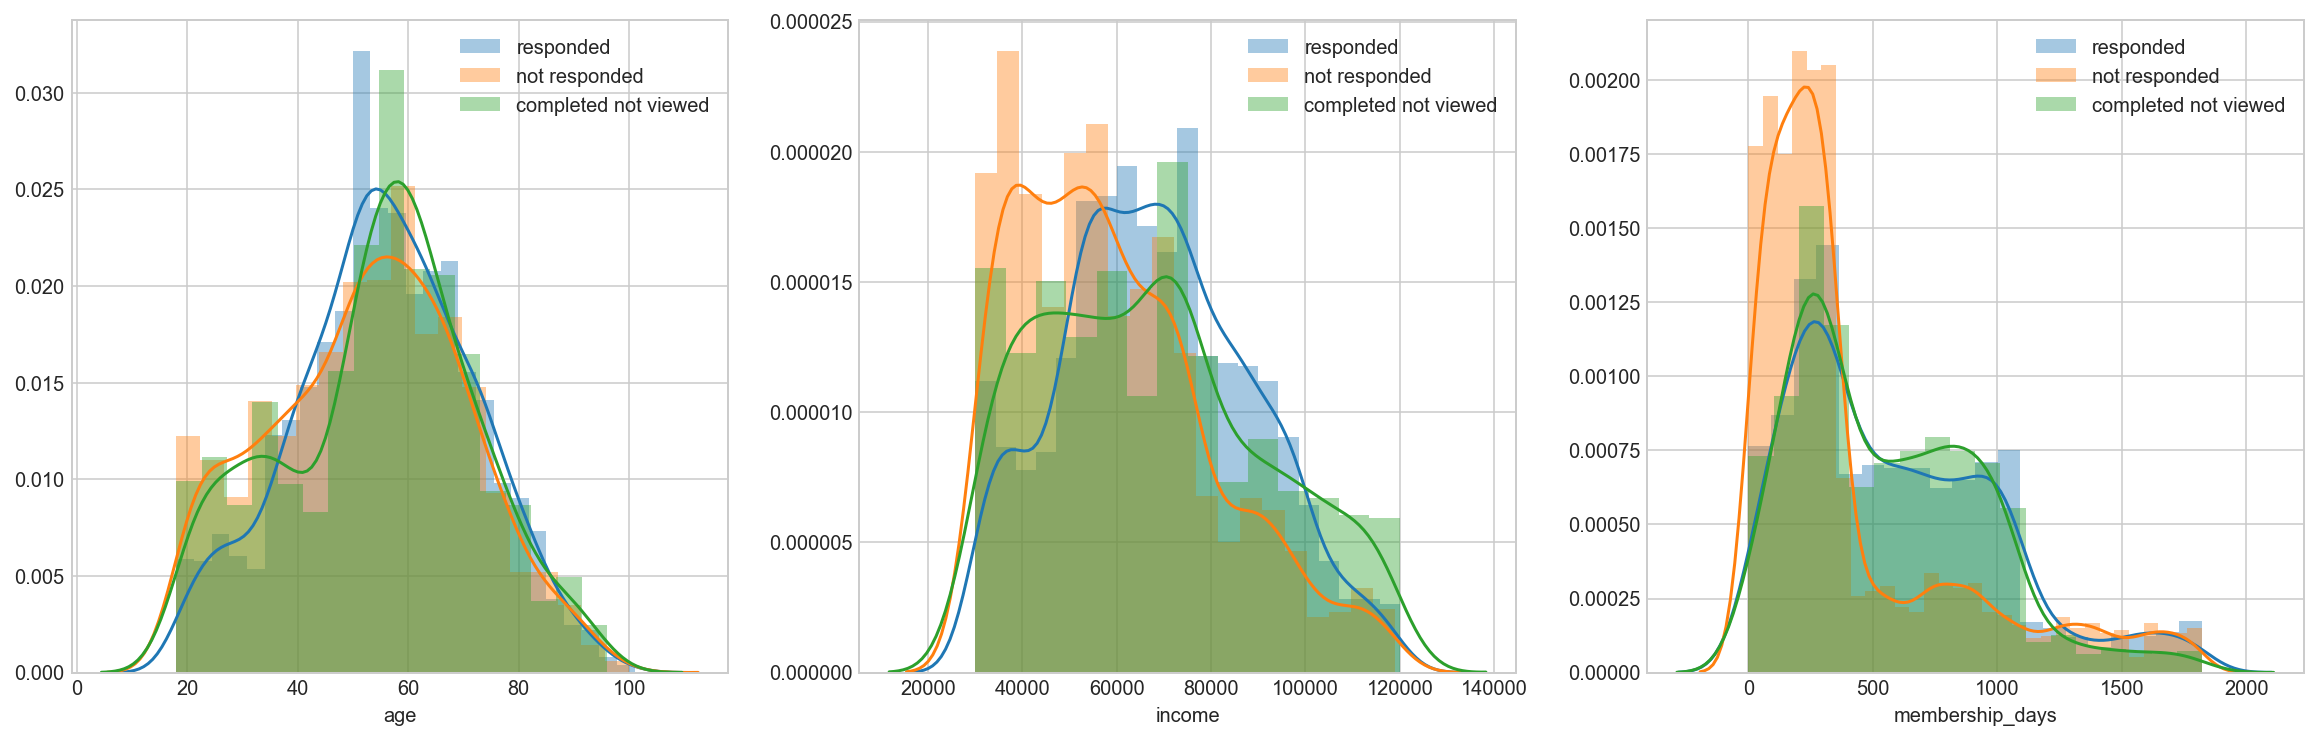

In [28]:
plot_compare_3_groups(create_offer_funnels('bogo_5_7_5'))

44.63 % customers responded to offers
54.42 % customers did not respond to any offer
0.95 % customers completed offers without viewing offer


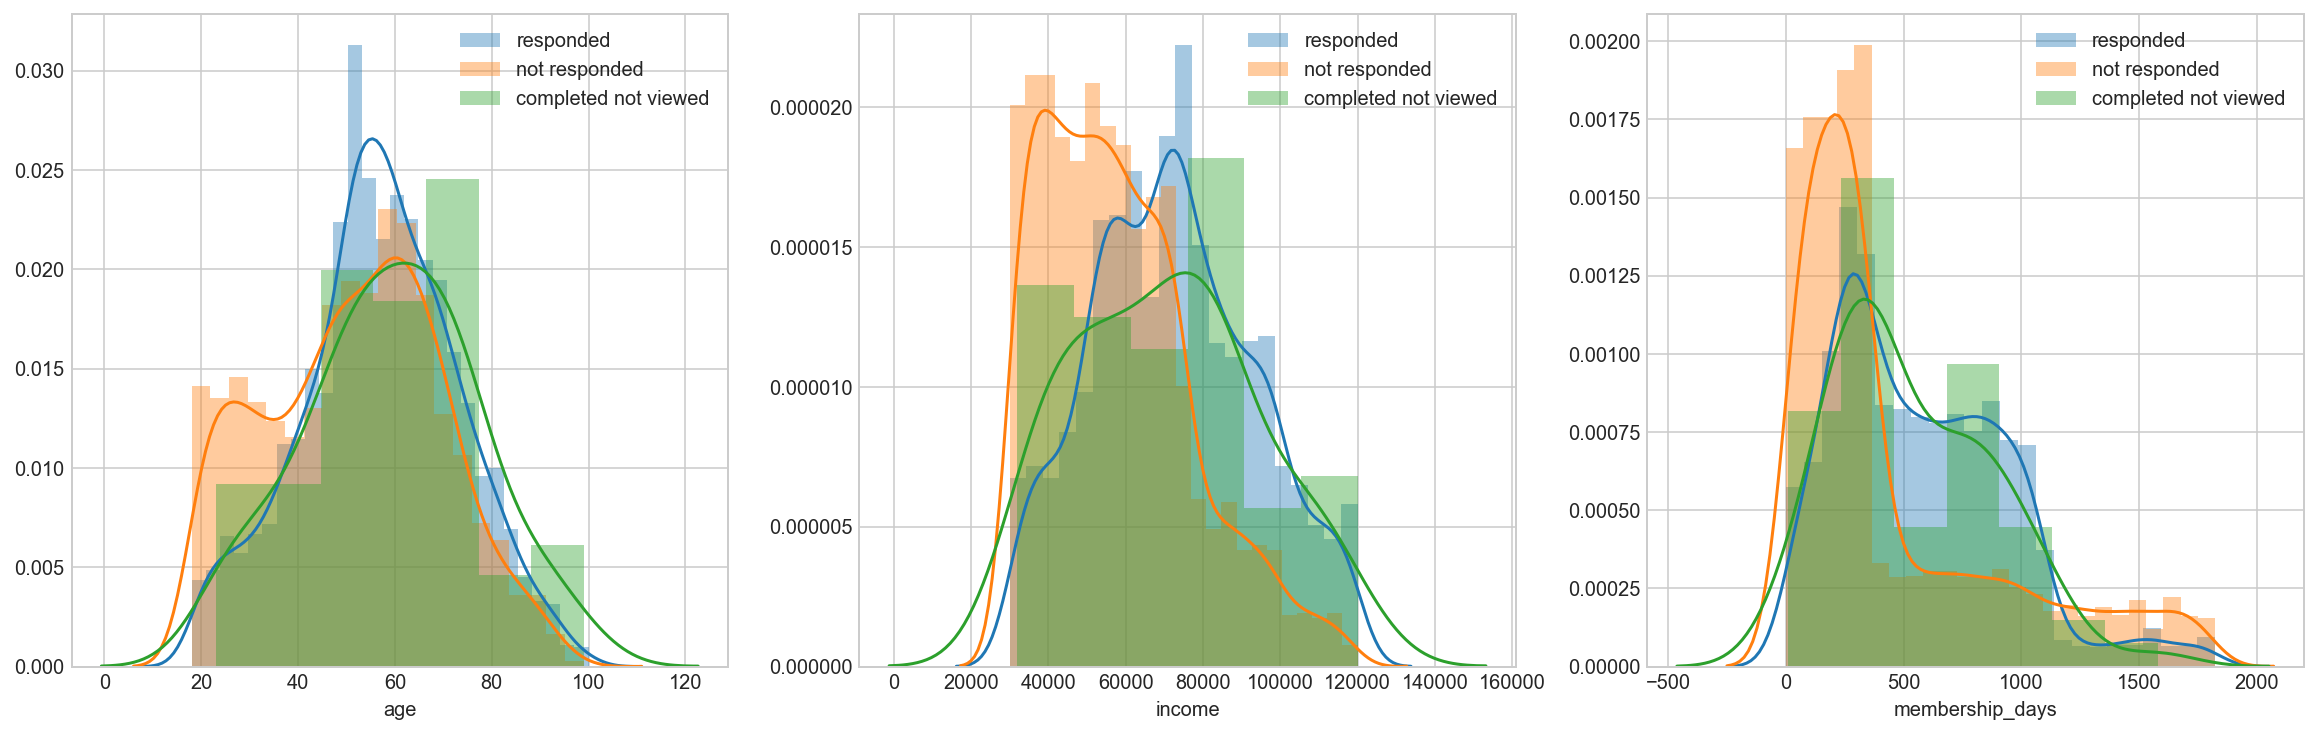

In [29]:
plot_compare_3_groups(create_offer_funnels('bogo_10_5_10'))

58.37 % customers responded to offers
40.26 % customers did not respond to any offer
1.37 % customers completed offers without viewing offer


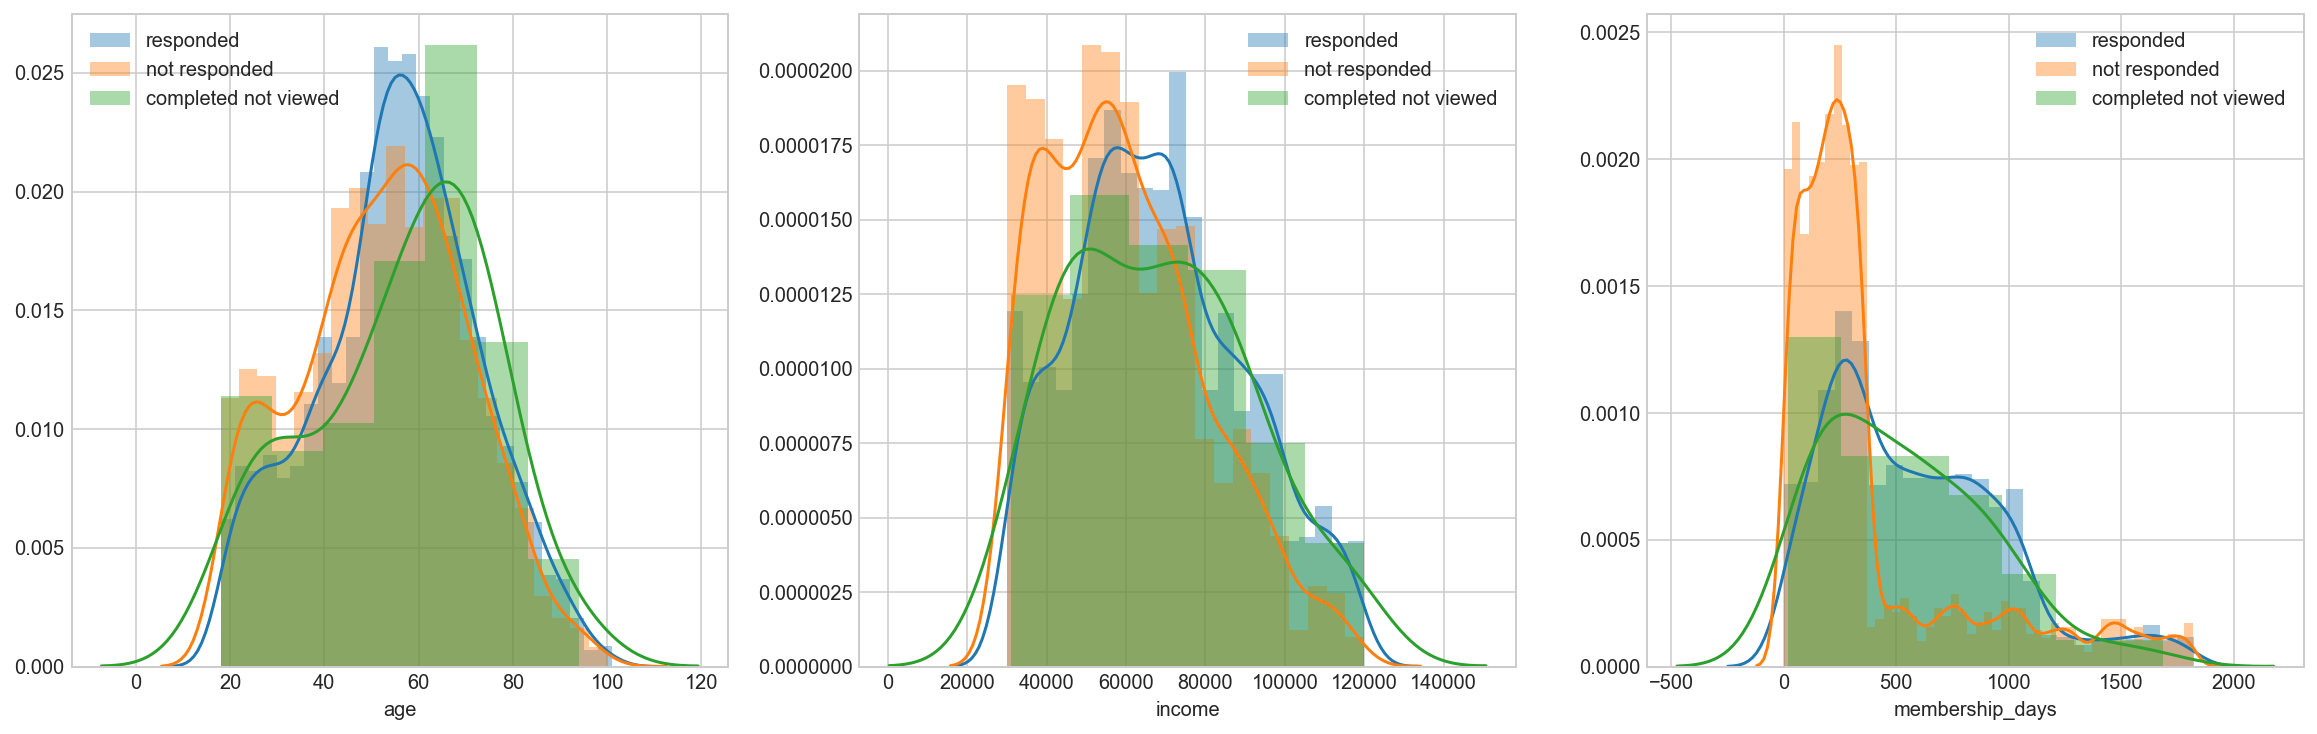

In [30]:
plot_compare_3_groups(create_offer_funnels('bogo_5_5_5'))

44.6 % customers responded to offers
50.16 % customers did not respond to any offer
5.24 % customers completed offers without viewing offer


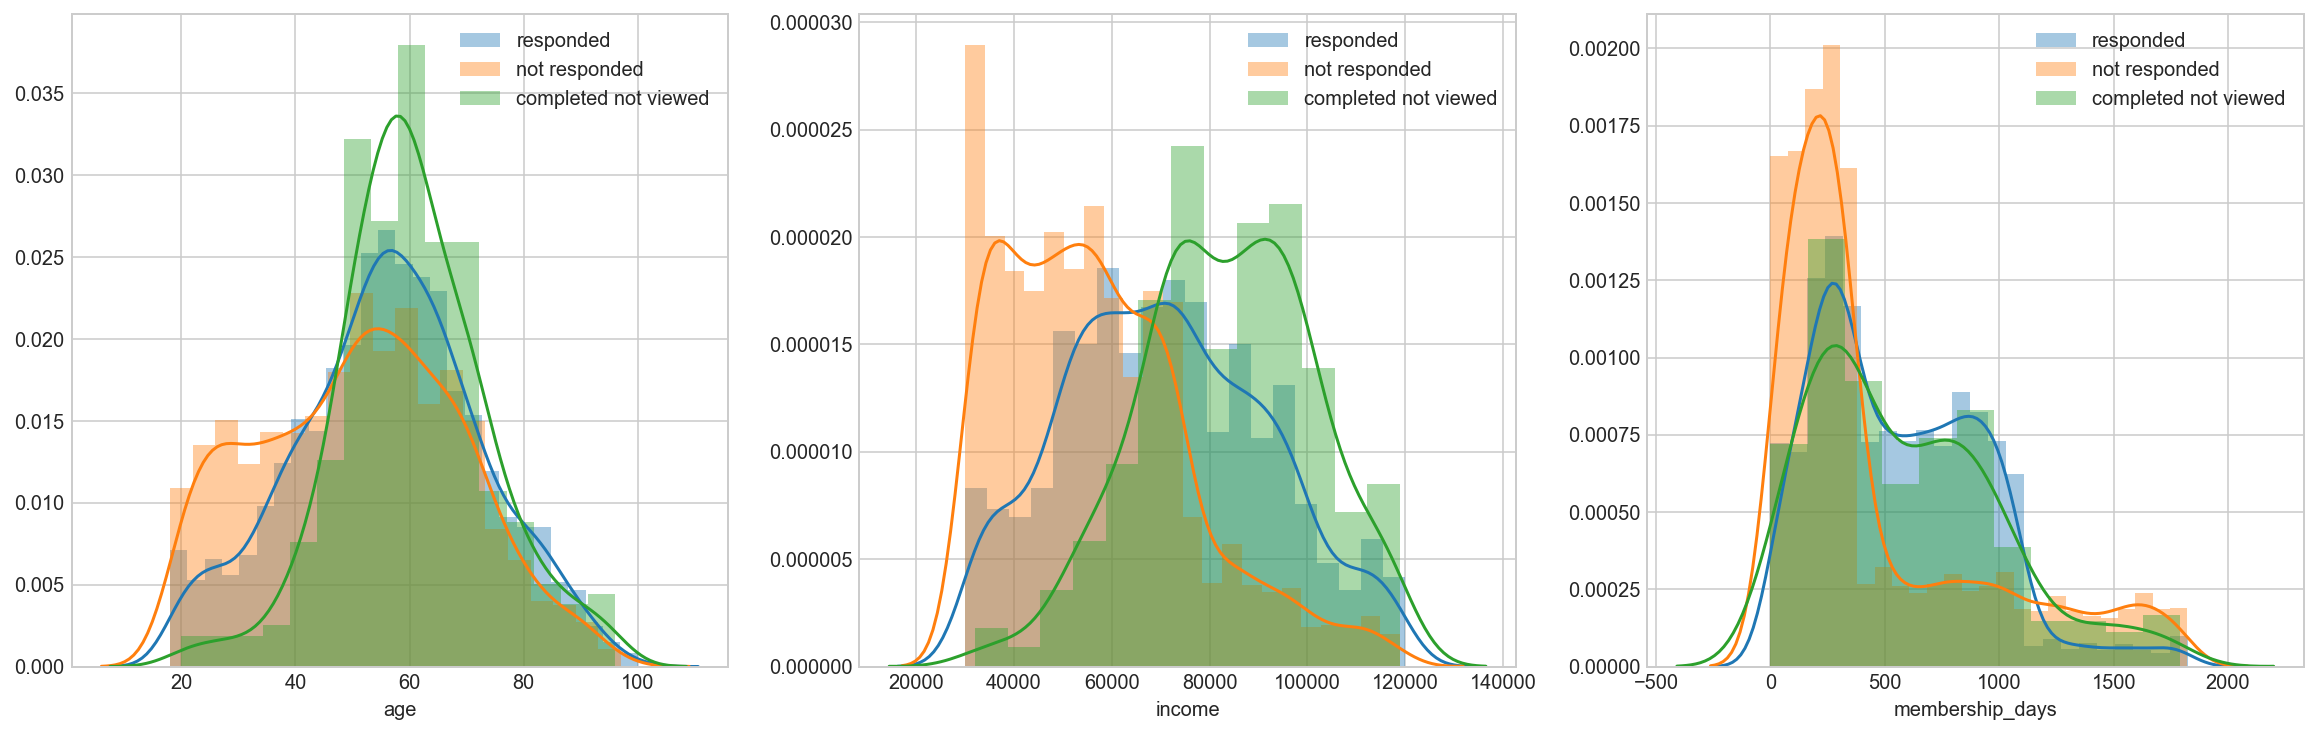

In [31]:
plot_compare_3_groups(create_offer_funnels('bogo_10_7_10'))

In [35]:
# Sample of 5 customers who responded to offer A
get_response_ids(customer_funnels)[:5]

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


Index(['0009655768c64bdeb2e877511632db8f', '0011e0d4e6b944f998e987f904e8c1e5',
       '0020c2b971eb4e9188eac86d93036a77', '0020ccbbb6d84e358d3414a3ff76cffd',
       '003d66b6608740288d6cc97a6903f4f0'],
      dtype='object', name='customer_id')

### Implementation
While we have a function to extract customer ids based on offer_type and offer_id, we can create new features in the customers data - whether the customer responded to offer A, offer B, ... discount offers, BOGO offers, etc.

In [36]:
responded, not_responded, completed_not_viewed = create_3_demo_groups(customer_funnels)

74.4 % customers responded to offers
24.54 % customers did not respond to any offer
1.06 % customers completed offers without viewing offer


In [38]:
customers['response'] = customers.id.isin(responded.index).astype(int)
customers.head()

,gender,age,id,became_member_on,income,membership_days,response
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,1
5,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,91,1
8,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,167,1
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,257,1


# Additional data cleaning before modeling

In [40]:
# Examine the ratios of target classes to decide on the classification metrics
# Accuracy seems like a good metric for balanced classes
print('discount response class ratios:')
print(customers.response.value_counts() / len(customers))

discount response class ratios:
1    0.797031
0    0.202969
Name: response, dtype: float64


 # Build Models to classify customer response to offers
- By predicting whether a customer will respond to a certain type of offer (discount / bogo), we can build focused marketing campaigns to maximize returns

## Notes:
- 55% of customers responded to discount offers while 45% didn't respond
- 51% of customers responded to bogo offers while 48 percent didn't respond
- Although classes are balanced, I would still choose F1 score as the metric
- Because I'd like to make sure all customers who will respond gets the offer, in the expense of those who won't respond getting the offer

In [41]:
customers.head()

,gender,age,id,became_member_on,income,membership_days,response
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,1
5,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,91,1
8,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,167,1
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,257,1


In [42]:
# Split customers data into X and y
X = customers[['gender','age','income','membership_days']]
# y = customers['discount']

# Convert categorical features into dummy variables
X = pd.get_dummies(X)

In [28]:
# print('cross validation scores for AdaBoost:', cross_val_score(AdaBoostClassifier(), X, y, scoring="f1", cv=5))
# print('cross validation scores for RandomForest:', cross_val_score(RandomForestClassifier(), X, y, scoring='f1', cv=5))
# print('cross validation scores for LogisticRegression:', cross_val_score(LogisticRegression(), X, y, scoring='f1', cv=5))

## Compare ROC AUC for both target variables (discount, bogo)

In [43]:
def compare_roc(target):

    # Set discount_response as the target variable
    y = customers[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train three models
    log_reg = LogisticRegression().fit(X_train, y_train)
    rfc = RandomForestClassifier().fit(X_train, y_train)
    adaboost = AdaBoostClassifier().fit(X_train, y_train)

    # Plot ROC comparisons
    temp = plot_roc_curve(rfc, X_test, y_test)
    plot_roc_curve(adaboost, X_test, y_test, ax=temp.ax_)
    plot_roc_curve(log_reg, X_test, y_test, ax=temp.ax_)
    plt.title(f'{target} offer ROC')

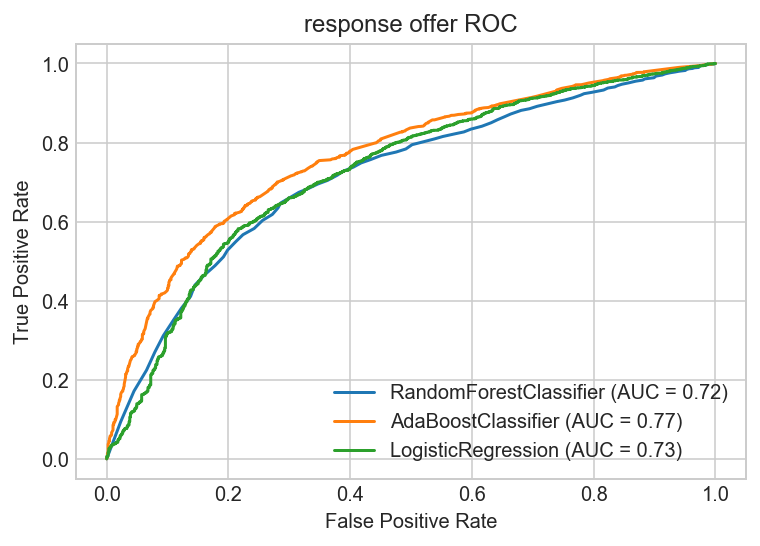

In [44]:
compare_roc('response')

# Use GridSearchCV to find the best parameters for AdaBoost

In [45]:
# Get available parameters
AdaBoostClassifier().get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [46]:
y = customers['response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'n_estimators': [10, 30, 50],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
}

bogo_cv = GridSearchCV(AdaBoostClassifier(), param_grid=parameters, scoring='f1', return_train_score=True)
bogo_cv.fit(X_train, y_train)
print(f'best parameters: {bogo_cv.best_params_}')
# print(bogo_cv.cv_results_)
y_pred = bogo_cv.predict(X_test)
print(f'f1 score on the test data: {f1_score(y_test, y_pred)}')

best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 10}
f1 score on the test data: 0.8941041785918717


### Find the optimal probability threshold for the highest F1 scores
- In practice, we can lower the threshold because there is little harm to send offers to those who won't respond

In [93]:
def find_best_threshold(model, plot=False):

    # create a hash table of thresholds vs f1 scores
    res = dict()
    y_proba_pred = model.predict_proba(X_test)[:,1]

    for threshold in np.linspace(0,1):
        res[threshold] = f1_score(y_test, [1 if p > threshold else 0 for p in y_proba_pred])

    # Find the optimal probability thresholds for the max f1 score
    for key,value in res.items():
        if value == max(res.values()):
            print(key)

    if plot == True:
        # plot probability threshold VS F1 scores
        plt.plot(list(res.keys()), list(res.values()));
        plt.title('F1 scores by probability thresholds');

0.2857142857142857
0.3061224489795918
0.32653061224489793
0.3469387755102041


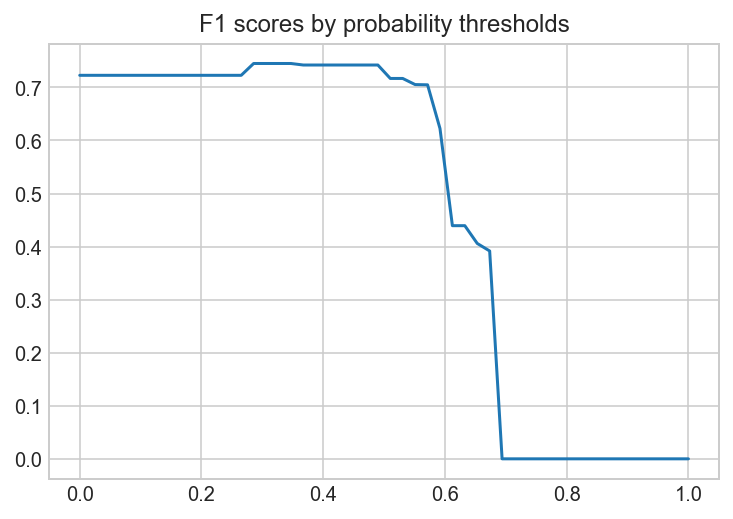

In [98]:
# The best threshold for predicting bogo response is between 0.28 and 0.34 for this test data
find_best_threshold(bogo_cv, plot=True)

0.2857142857142857
0.3061224489795918
0.32653061224489793
0.3469387755102041
0.36734693877551017
0.3877551020408163
0.4081632653061224
0.42857142857142855
0.44897959183673464


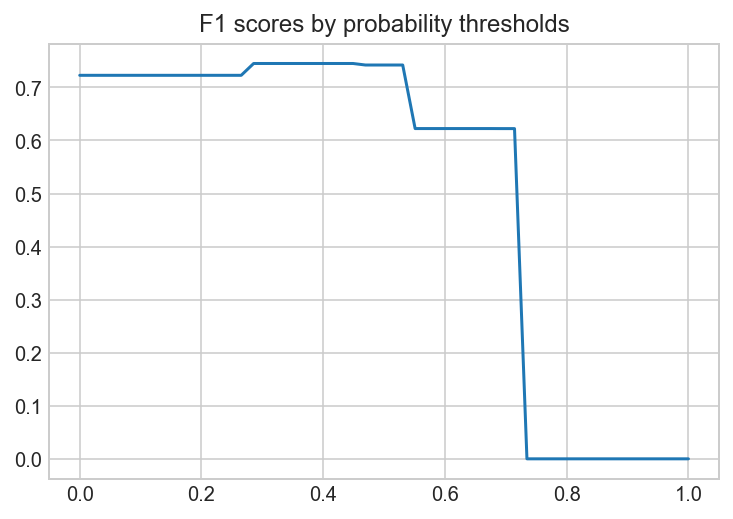

In [101]:
# The best threshold for predicting discount response is between 0.28 and 0.45 for this test data
find_best_threshold(discount_cv, plot=True)

In [102]:
# Save the two models for classifying discount and bogo responses
joblib.dump(discount_cv, 'discount_clf.pkl')
joblib.dump(bogo_cv, 'bogo_clf.pkl')

['bogo_clf.pkl']